In [1]:
from scipy.io import loadmat
train_idxs = loadmat('cuhk03_new_protocol_config_labeled.mat')['train_idx'].flatten()

In [2]:
import json
import numpy as np
import matplotlib.pyplot as plt

with open("PR_data/feature_data.json", "r") as file:
    features = json.load(file)
    
data_features = np.asarray(features)

print('Data shape: {}'.format(data_features.shape))

Data shape: (14096, 2048)


In [3]:
#Load labels
labelss = loadmat('cuhk03_new_protocol_config_labeled.mat')['labels'].flatten()

#Load camId
cam_Ids = loadmat('cuhk03_new_protocol_config_labeled.mat')['camId'].flatten()

#Load indexes
train_idxs = loadmat('cuhk03_new_protocol_config_labeled.mat')['train_idx'].flatten()
query_idxs = loadmat('cuhk03_new_protocol_config_labeled.mat')['query_idx'].flatten()
gallery_idxs = loadmat('cuhk03_new_protocol_config_labeled.mat')['gallery_idx'].flatten()

#Load training indexes
print("training indexes : {}".format(train_idxs.shape))
print("query indexes : {}".format( query_idxs.shape))
print("gallery indexes : {}".format( gallery_idxs.shape))

training indexes : (7368,)
query indexes : (1400,)
gallery indexes : (5328,)


In [4]:
#converting to python index notation

train_idxs = train_idxs - 1
query_idxs = query_idxs - 1
gallery_idxs = gallery_idxs - 1

In [5]:
train_f = []
train_label = []
train_camid = []
# divide the features data into training 
for i in range (len(train_idxs)):
    train_f.append(data_features[train_idxs[i]])
    train_camid.append(cam_Ids[train_idxs[i]])
    train_label.append(labelss[train_idxs[i]])
    
train_f = np.asarray(train_f)    
train_label = np.asarray(train_label)
train_camid = np.asarray(train_camid)

In [6]:
#features, cam, label data into gallery
query_f = []
query_camid = []
query_label = []

for i in range (len(query_idxs)):
    query_f.append(data_features[query_idxs[i]])
    query_camid.append(cam_Ids[query_idxs[i]])
    query_label.append(labelss[query_idxs[i]])
    
query_f = np.asarray(query_f) 
query_label = np.asarray(query_label)
query_camid = np.asarray(query_camid)

In [7]:
#features, cam, label data into gallery
gallery_f = []
gallery_camid = []
gallery_label = []

for i in range (len(gallery_idxs)):
    gallery_f.append(data_features[gallery_idxs[i]])
    gallery_camid.append(cam_Ids[gallery_idxs[i]])
    gallery_label.append(labelss[gallery_idxs[i]])
       
gallery_f = np.asarray(gallery_f)  
gallery_camid = np.asarray(gallery_camid)  
gallery_label = np.asarray(gallery_label)  

In [8]:
#stacking labels, cam ids and features

query = np.vstack((query_f.T, query_label, query_camid)) #transpose feature matrix to match dimensions 
gallery = np.vstack((gallery_f.T, gallery_label, gallery_camid)) #transpose feature matrix to match dimensions 

#transpose back to get right shape
query = query.T
gallery = gallery.T

print(query[:,-2])
print(gallery.shape)

[   3.    3.    6. ... 1461. 1463. 1463.]
(5328, 2050)


In [20]:
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier

k = 50 #number of nearest neighbors parameter

rank = []
distance = []
idx = []

import time
start_time = time.time()

##sqeuclidean instead of euclidean for computing efficientcy. As we are only interested in the ranklists
##and not the actual values of the distances.

for i in range (len(query[:,0])):
    
    ##getting rid of label/camid repetions 
    gallery_no_rep = gallery[~np.logical_and((gallery[:,-1] == query[i, -1]), (gallery[:,-2] == query[i, -2]))]
    
    NN = NearestNeighbors(n_neighbors = k, metric = 'sqeuclidean') #setting up NN
    NN.fit(gallery_no_rep[:,:-2], gallery_no_rep[:,-2])

   
    query_f_test = query_f[i,:].reshape(1,-1)
    dist, idxs = NN.kneighbors(query_f_test)
    
    distance.append(dist)
    idx.append(idxs)

distance = np.asarray(distance)
idx = np.asarray(idx)

print(idx.shape)

##creating ranklist of predicted labels (1400x10)
for i in range (len(query[:,0])):
    row_rank = []
    for j in range (len(idx[0,:])):
        row_rank.append(gallery[idx[i,j],-2])
    rank.append(row_rank)
    
rank = np.asarray(rank)     

    
print("--- %s seconds ---" % (time.time() - start_time))

print(rank.shape)

(1400, 1, 50)
--- 162.3848021030426 seconds ---
(1400, 1, 50)


In [22]:
rank = np.squeeze(rank)
print(rank.shape)
print(rank)

query_label = query_label.reshape(1400,1)

rank_bin1 = []

for i in range (len(rank[:,0])):
    rank_bin = []
    for j in range (len(rank[0,:])): 
        if (rank[i,j] == query_label[i]):   ##if match, set 1, otherwise set 0
            rank_bin.append(1)
        else:
            rank_bin.append(0)
    rank_bin1.append(rank_bin)
    
    
rank_bin1 = np.asarray(rank_bin1)   ##array of label matches and mismatches
print(rank_bin1)

(1400, 50)
[[1367.  739. 1426. ...   47. 1367. 1368.]
 [ 509.  232.  232. ...  119.  530.  267.]
 [   6.    6.    6. ...  267.   72.  635.]
 ...
 [1418. 1418. 1461. ...  872.   91.   91.]
 [1463. 1463. 1463. ... 1139.  888.  832.]
 [1463. 1463.  884. ...  816.  884.  911.]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 ...
 [0 0 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 0 ... 0 0 0]]


In [30]:
rank_1 = np.sum(rank_bin1[:,0])/1400
r5 = rank_bin1[:,:5].sum(axis = 1)/5
rank_5 = np.count_nonzero(r5)/1400
r10 = rank_bin1[:,:10].sum(axis = 1)/10
rank_10 = np.count_nonzero(r10)/1400

print("Accuracy")
print("rank 1: %s" % (rank_1))
print("rank 5: %s" % (rank_5))
print("rank 10: %s" % (rank_10))

rank_tot0 = []
for i in range (1,k+1):
    r = rank_bin1[:,:i].sum(axis = 1)
    rank_ = np.count_nonzero(r)/1400
    rank_tot0.append(rank_)
print(rank_tot0)

Accuracy
rank 1: 0.4757142857142857
rank 5: 0.6742857142857143
rank 10: 0.7564285714285715
[0.4757142857142857, 0.5528571428571428, 0.6085714285714285, 0.6385714285714286, 0.6742857142857143, 0.6957142857142857, 0.7164285714285714, 0.7314285714285714, 0.7478571428571429, 0.7564285714285715, 0.765, 0.7728571428571429, 0.78, 0.7885714285714286, 0.8014285714285714, 0.8092857142857143, 0.8178571428571428, 0.825, 0.8314285714285714, 0.8342857142857143, 0.8371428571428572, 0.845, 0.8471428571428572, 0.8528571428571429, 0.8585714285714285, 0.8614285714285714, 0.8635714285714285, 0.8657142857142858, 0.8692857142857143, 0.87, 0.8742857142857143, 0.8742857142857143, 0.8778571428571429, 0.8814285714285715, 0.8828571428571429, 0.885, 0.8871428571428571, 0.89, 0.8907142857142857, 0.8914285714285715, 0.8942857142857142, 0.895, 0.8971428571428571, 0.9, 0.9007142857142857, 0.9021428571428571, 0.9057142857142857, 0.9078571428571428, 0.91, 0.9114285714285715]


In [46]:
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier

k = 50 #number of nearest neighbors parameter

rank = []
distance = []
idx = []

import time
start_time = time.time()

##sqeuclidean instead of euclidean for computing efficientcy. As we are only interested in the ranklists
##and not the actual values of the distances.

for i in range (len(query[:,0])):
    
    ##getting rid of label/camid repetions 
    gallery_no_rep = gallery[~np.logical_and((gallery[:,-1] == query[i, -1]), (gallery[:,-2] == query[i, -2]))]
    
    NN = NearestNeighbors(n_neighbors = k, metric = 'chebyshev') #setting up NN
    NN.fit(gallery_no_rep[:,:-2], gallery_no_rep[:,-2])

   
    query_f_test = query_f[i,:].reshape(1,-1)
    dist, idxs = NN.kneighbors(query_f_test)
    
    distance.append(dist)
    idx.append(idxs)

distance = np.asarray(distance)
idx = np.asarray(idx)

print(idx.shape)

##creating ranklist of predicted labels (1400x10)
for i in range (len(query[:,0])):
    row_rank = []
    for j in range (len(idx[0,:])):
        row_rank.append(gallery[idx[i,j],-2])
    rank.append(row_rank)
    
rank = np.asarray(rank)     

    
print("--- %s seconds ---" % (time.time() - start_time))

print(rank.shape)

rank = np.squeeze(rank)
print(rank.shape)
print(rank)

query_label = query_label.reshape(1400,1)

rank_bin1 = []

for i in range (len(rank[:,0])):
    rank_bin = []
    for j in range (len(rank[0,:])): 
        if (rank[i,j] == query_label[i]):   ##if match, set 1, otherwise set 0
            rank_bin.append(1)
        else:
            rank_bin.append(0)
    rank_bin1.append(rank_bin)
    
    
rank_bin1 = np.asarray(rank_bin1)   ##array of label matches and mismatches
print(rank_bin1)

rank_1 = np.sum(rank_bin1[:,0])/1400
r5 = rank_bin1[:,:5].sum(axis = 1)/5
rank_5 = np.count_nonzero(r5)/1400
r10 = rank_bin1[:,:10].sum(axis = 1)/10
rank_10 = np.count_nonzero(r10)/1400

print("Accuracy")
print("rank 1: %s" % (rank_1))
print("rank 5: %s" % (rank_5))
print("rank 10: %s" % (rank_10))

rank_tot = []
for i in range (1,k+1):
    r = rank_bin1[:,:i].sum(axis = 1)
    rank_ = np.count_nonzero(r)/1400
    rank_tot.append(rank_)
print(rank_tot)

(1400, 1, 50)
--- 1408.9290990829468 seconds ---
(1400, 1, 50)
(1400, 50)
[[ 739.  725.  725. ...  738. 1372. 1368.]
 [ 232.   81. 1426. ...  672.  736.  625.]
 [   6.    6.    6. ...  442.  349.  267.]
 ...
 [1418. 1418. 1418. ...  872.  743.  645.]
 [1463. 1300.  238. ...  238.  474. 1342.]
 [1463.  884.  884. ...  720.  988.  767.]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]]
Accuracy
rank 1: 0.34285714285714286
rank 5: 0.5257142857142857
rank 10: 0.625
[0.34285714285714286, 0.4114285714285714, 0.4664285714285714, 0.4942857142857143, 0.5257142857142857, 0.5514285714285714, 0.5728571428571428, 0.5942857142857143, 0.6157142857142858, 0.625, 0.6435714285714286, 0.6557142857142857, 0.6621428571428571, 0.6721428571428572, 0.68, 0.6907142857142857, 0.6985714285714286, 0.7028571428571428, 0.7092857142857143, 0.7128571428571429, 0.7185714285714285, 0.7221428571428572, 0.7292857142857143, 0.7357142857142858, 0.737142

In [ ]:
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier

k = 50 #number of nearest neighbors parameter

rank = []
distance = []
idx = []

import time
start_time = time.time()

##sqeuclidean instead of euclidean for computing efficientcy. As we are only interested in the ranklists
##and not the actual values of the distances.

for i in range (len(query[:,0])):
    
    ##getting rid of label/camid repetions 
    gallery_no_rep = gallery[~np.logical_and((gallery[:,-1] == query[i, -1]), (gallery[:,-2] == query[i, -2]))]
    
    NN = NearestNeighbors(n_neighbors = k, metric = 'cosine') #setting up NN
    NN.fit(gallery_no_rep[:,:-2], gallery_no_rep[:,-2])

   
    query_f_test = query_f[i,:].reshape(1,-1)
    dist, idxs = NN.kneighbors(query_f_test)
    
    distance.append(dist)
    idx.append(idxs)

distance = np.asarray(distance)
idx = np.asarray(idx)

print(idx.shape)

##creating ranklist of predicted labels (1400x10)
for i in range (len(query[:,0])):
    row_rank = []
    for j in range (len(idx[0,:])):
        row_rank.append(gallery[idx[i,j],-2])
    rank.append(row_rank)
    
rank = np.asarray(rank)     

    
print("--- %s seconds ---" % (time.time() - start_time))

print(rank.shape)

rank = np.squeeze(rank)
print(rank.shape)
print(rank)

query_label = query_label.reshape(1400,1)

rank_bin1 = []

for i in range (len(rank[:,0])):
    rank_bin = []
    for j in range (len(rank[0,:])): 
        if (rank[i,j] == query_label[i]):   ##if match, set 1, otherwise set 0
            rank_bin.append(1)
        else:
            rank_bin.append(0)
    rank_bin1.append(rank_bin)
    
    
rank_bin1 = np.asarray(rank_bin1)   ##array of label matches and mismatches
print(rank_bin1)

rank_1 = np.sum(rank_bin1[:,0])/1400
r5 = rank_bin1[:,:5].sum(axis = 1)/5
rank_5 = np.count_nonzero(r5)/1400
r10 = rank_bin1[:,:10].sum(axis = 1)/10
rank_10 = np.count_nonzero(r10)/1400

print("Accuracy")
print("rank 1: %s" % (rank_1))
print("rank 5: %s" % (rank_5))
print("rank 10: %s" % (rank_10))

rank_tot1 = []
for i in range (1,k+1):
    r = rank_bin1[:,:i].sum(axis = 1)
    rank_ = np.count_nonzero(r)/1400
    rank_tot1.append(rank_)
print(rank_tot1)

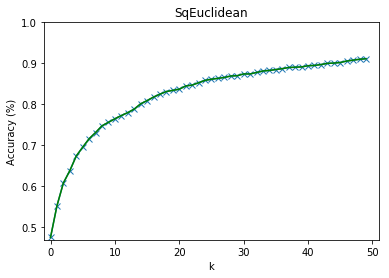

In [45]:
plt.figure()
x=np.arange(0, 2576, 1)
plt.axis([-1,51, 0.47, 1])
plt.plot(rank_tot0, 'x-')
plt.plot(rank_tot, linewidth = 1.5, c = 'g')
plt.title('SqEuclidean')
plt.ylabel('Accuracy (%)')
plt.xlabel('k')
plt.grid(False)
plt.savefig('RecAcc.pdf', format='pdf', dpi=300)
plt.show()